In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/content/ALLFLOWMETER_HIKARI2021.csv')

In [ ]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [ ]:
df.head()

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,Cg61Jch3vdz9DBptj,103.255.15.23,13316,128.199.242.104,443,2.207588,15,14,6,6,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,1
1,CdRIlqLWdj35Y9vW9,103.255.15.23,13318,128.199.242.104,443,15.624266,15,14,6,6,...,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,1
2,CLzp9Khd0Y09Qkgrg,103.255.15.23,13320,128.199.242.104,443,12.203357,14,13,6,5,...,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,1
3,Cnf1YA4iLB4CSNWB88,103.255.15.23,13322,128.199.242.104,443,9.992448,14,13,6,5,...,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,1
4,C4ZKvv3fpO72EAOsJ6,103.255.15.23,13324,128.199.242.104,443,7.780611,14,14,6,5,...,7.545305e+06,7.545305e+06,7.545305e+06,7.545305e+06,0.0,29200,65160,0,Bruteforce-XML,1


In [ ]:
df['traffic_category'].value_counts(normalize=True)

Benign                 0.625688
Background             0.306425
Probing                0.042119
Bruteforce             0.010596
Bruteforce-XML         0.009266
XMRIGCC CryptoMiner    0.005905
Name: traffic_category, dtype: float64

In [ ]:
# Only want to look at probing for the problem statement and there is a decent amount of data for this
df[df['traffic_category'] == 'Probing']

,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
528611,CGUZ413E20vOAvNhB6,103.255.15.150,33864,128.199.242.104,443,134.545802,1308,2571,1290,1292,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528612,CtEHvV2t8Szv3EMrH4,103.255.15.150,33866,128.199.242.104,443,133.710978,1287,2530,1264,1269,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528613,Ck8Zli1W2a7NZ1LYf2,103.255.15.150,33868,128.199.242.104,443,133.558816,1280,2525,1263,1265,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
528614,CWTrKw3CQJJ6cxZIV1,103.255.15.150,33870,128.199.242.104,443,133.516534,17,17,7,8,...,2.756750e+07,1.051647e+08,1.327322e+08,6.636612e+07,5.486954e+07,29200,65160,0,Probing,1
528615,CDlGBc2wH71BlkMHWb,103.255.15.150,33872,128.199.242.104,443,133.430967,1287,2544,1270,1274,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,0,Probing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551994,CWnqOE3MwhYBqWV0l5,103.255.15.150,33848,128.199.242.104,443,0.249909,10,14,3,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551995,Cc9GuT23r4uUSE8Syf,103.255.15.150,33852,128.199.242.104,443,0.253536,9,12,3,7,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551996,CEo1Cq1YIRzA5Tmzyi,103.255.15.150,33854,128.199.242.104,443,0.258555,9,12,3,7,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1
551997,CwnAuE4prskuSDNTq6,103.255.15.150,33856,128.199.242.104,443,0.244943,10,13,3,8,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,29200,65160,402,Probing,1


In [ ]:
df = df[(df['traffic_category'] == 'Benign') | (df['traffic_category'] == 'Probing')]
df = df.select_dtypes(include=[np.number])

# Identification of num_features to use

Strategy: I will use a basic logistic regression model on multiple SelectKBest k values to see which level of values results in the highest accuracy. This way, I have a scientific methodology as to how I am selecting the number of features that I will be using for my exploratory data analysis and modeling stages.

In [ ]:
def feature_selection(df:pd.DataFrame):
  # Initialize DataFrame
  scores_df = pd.DataFrame(columns=[
                                    'k',
                                    'train_acc',
                                    'test_acc'
  ])

  for i in range(81):
    # For each iteration, running SelectKBest with however many features as reflected in the iteration of the for loop
    fvalue_selector = SelectKBest(f_classif, k=(i + 1))
    X_best_features = fvalue_selector.fit_transform(
      df.drop(columns=['Label']), df['Label'])
    
    # Initialize Logistic Regression
    lr = LogisticRegression(
        max_iter=10000, 
        random_state=42)
    
    # Defining X and y
    X = df[[col for col in df if col in df.columns[fvalue_selector.get_support(indices=True)].tolist()]].copy()
    y = df['Label']

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    # Fit and score
    lr.fit(X_train, y_train)
    train_acc = lr.score(X_train, y_train)
    test_acc = lr.score(X_test, y_test)

    # Add to scores_df DataFrame
    scores_df.loc[i] = [
                        (i + 1),
                        train_acc,
                        test_acc
    ]

  # scores_df
  return scores_df.sort_values(by=['test_acc'], ascending=False).head(10)

In [ ]:
feature_selection(df)

In [ ]:
fvalue_selector = SelectKBest(f_classif, k=15)
X_best_features = fvalue_selector.fit_transform(
    df.select_dtypes(include=[np.number]).drop(columns=['Label']), df['Label'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [23 24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
df_kbest = df[[col for col in df if col in df.columns[fvalue_selector.get_support(indices=True)].tolist()]].copy()
df_kbest['label'] = df['Label']
df_kbest.loc[~(df_kbest < 0).all(axis=1)]
df_kbest.head()

,fwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_min,fwd_header_size_max,bwd_header_size_min,bwd_header_size_max,bwd_URG_flag_count,flow_CWR_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,bwd_pkts_payload.tot,fwd_bulk_packets,idle.tot,idle.avg,label
181180,0.023696,0.023696,0.0,8,8,0,0,0,0,40.0,40.0,0.0,0.0,5.359472e+09,4.253549e+07,0
181181,0.023636,0.023636,0.0,8,8,0,0,0,0,40.0,40.0,0.0,0.0,6.811640e+09,4.257275e+07,0
181182,0.023797,0.023797,0.0,8,8,0,0,0,0,40.0,40.0,0.0,0.0,3.277740e+09,4.256806e+07,0
181183,5489.926702,10979.853403,1.0,40,40,20,20,0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0
181184,11214.716578,22429.433155,1.0,40,40,20,20,0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0


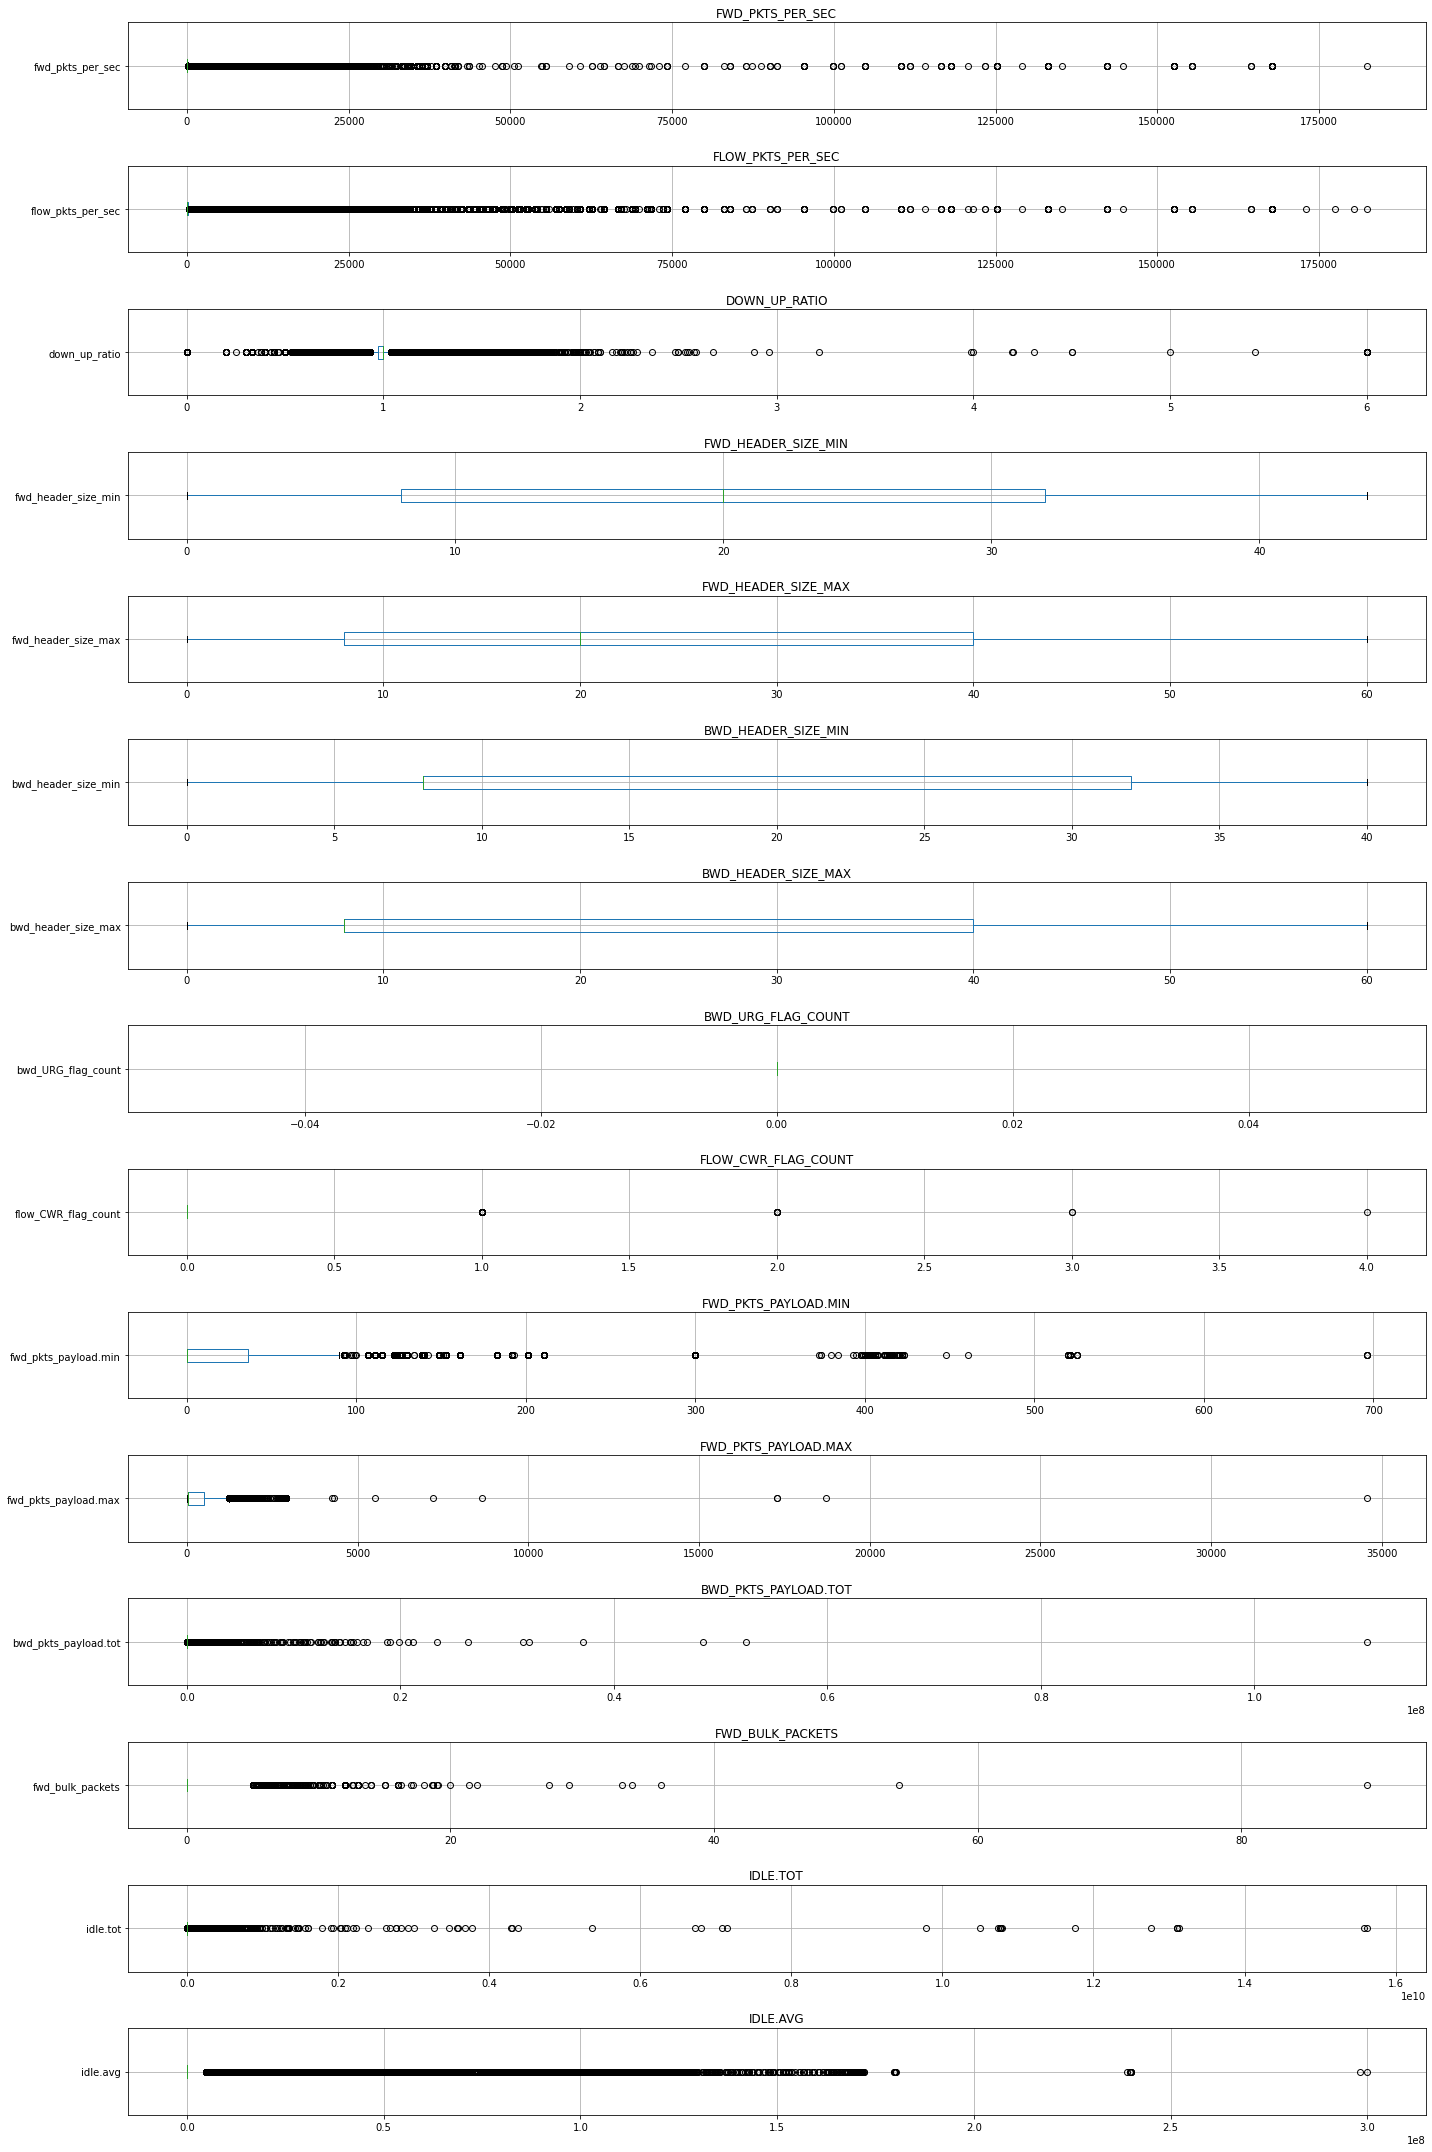

In [ ]:
# Figure for subplots (boxplots)
import math

plt.figure(figsize=(20, 30))

for i, col in enumerate(df_kbest.drop(columns=['label'])):
    # add a new subplot iteratively
    ax = plt.subplot(math.ceil(len(df_kbest.columns) - 1), 1, i+1)

    df_kbest.boxplot(col, vert=False, ax=ax)
  
    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

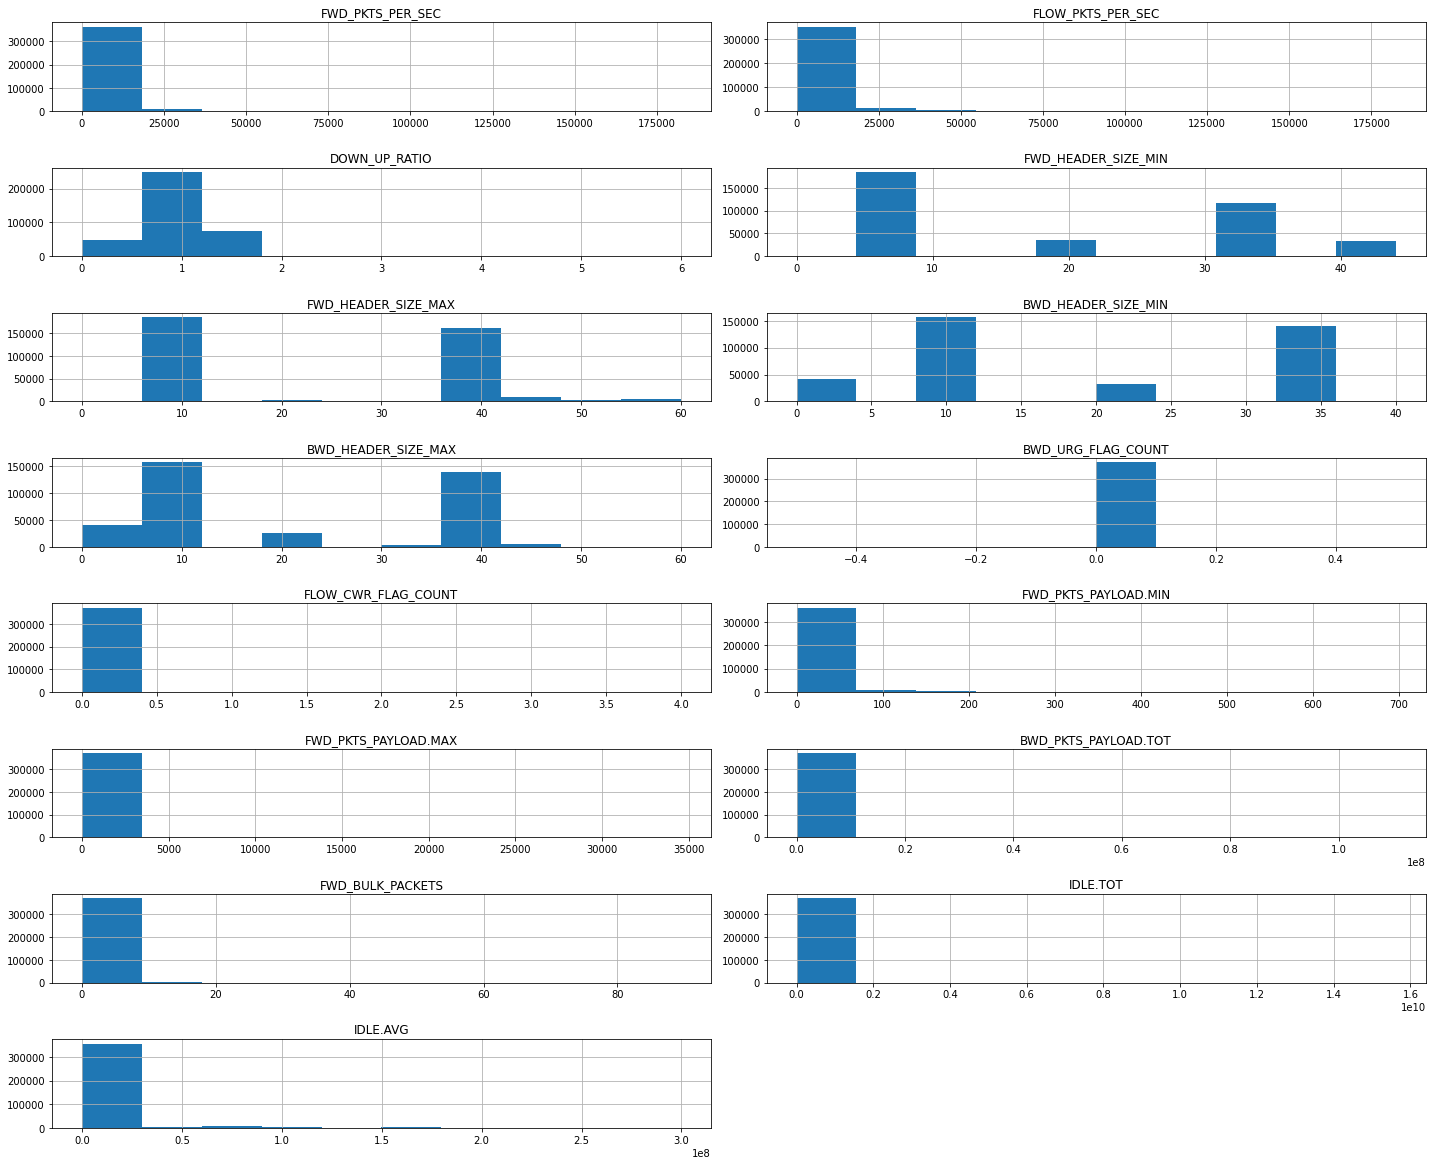

In [ ]:
# Figure for subplots (boxplots)
import math

plt.figure(figsize=(20, 30))

for i, col in enumerate(df_kbest.drop(columns=['label'])):
    # add a new subplot iteratively
    ax = plt.subplot(math.ceil(len(df_kbest.columns) - 1), 2, i+1)

    df_kbest[col].hist()
  
    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

This is a very sparse dataset with no columns that have a normal distribution. When scaling, I will need to use MinMaxScaler instead of StandardScaler, and when examining distributions, I will need to use a logarithmic scale.

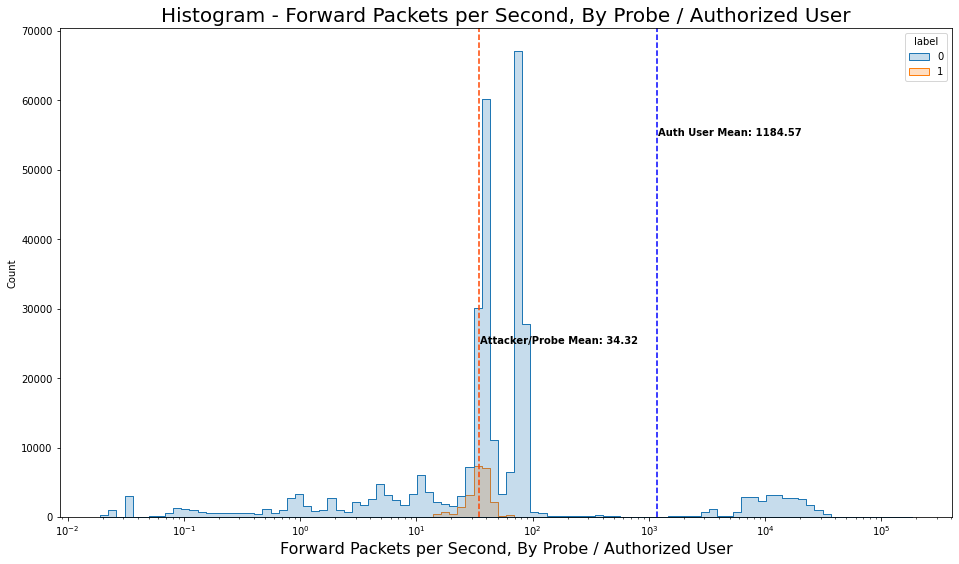

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Forward Packets per Second, By Probe / Authorized User', fontsize=20)
plt.xlabel('Forward Packets per Second, By Probe / Authorized User', fontsize=16)

auth_user_fp_mean = df_kbest.groupby('label')['fwd_pkts_per_sec'].mean()[0]
attacker_fp_mean = df_kbest.groupby('label')['fwd_pkts_per_sec'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_fp_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_fp_mean + 2, 
    55000,
    f'Auth User Mean: {round(auth_user_fp_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_fp_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_fp_mean + 1, 
    25000,
    f'Attacker/Probe Mean: {round(attacker_fp_mean, 2)}',
    weight='bold')

sns.histplot(df_kbest[df_kbest['fwd_pkts_per_sec'] > 0], x='fwd_pkts_per_sec', hue='label', element='step', log_scale=True, bins=100);

Authorized user behavior (blue) seems to have a bimodal distribution while probing behavior has a non-normal right skew distribution (logarithmic scale shown on histogram).

Note: Why is there a subpopulation around 10^4

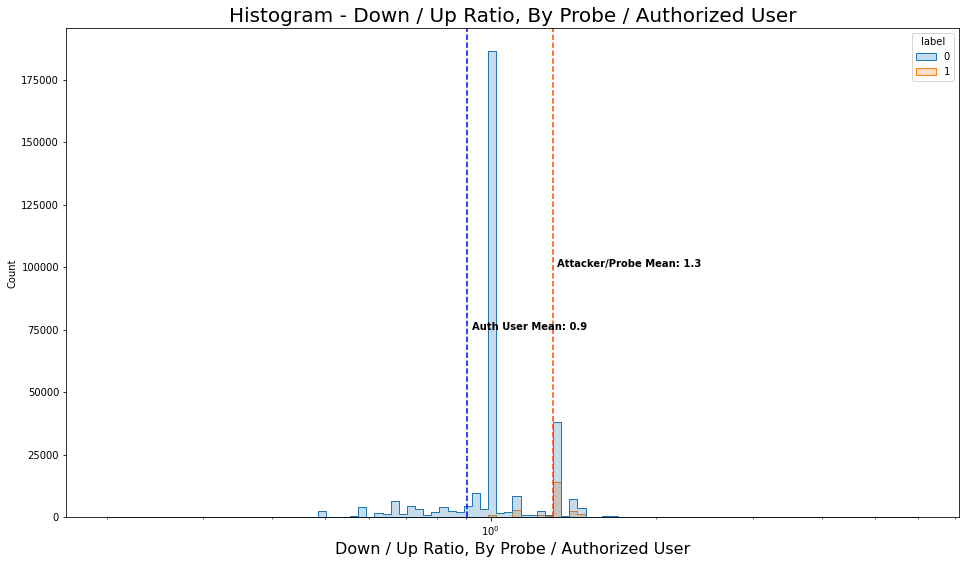

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Histogram - Down / Up Ratio, By Probe / Authorized User', fontsize=20)
plt.xlabel('Down / Up Ratio, By Probe / Authorized User', fontsize=16)

auth_user_dur_mean = df_kbest.groupby('label')['down_up_ratio'].mean()[0]
attacker_dur_mean = df_kbest.groupby('label')['down_up_ratio'].mean()[1]

# Auth User Mean Line
plt.axvline(
    auth_user_dur_mean, 
    c='blue', 
    ls='--')
plt.text(
    auth_user_dur_mean + .02, 
    75000,
    f'Auth User Mean: {round(auth_user_dur_mean, 2)}',
    weight='bold')

# Attacker Mean Line
plt.axvline(
    attacker_dur_mean, 
    c='orangered', 
    ls='--')
plt.text(
    attacker_dur_mean + .02, 
    100000,
    f'Attacker/Probe Mean: {round(attacker_dur_mean, 2)}',
    weight='bold')

sns.histplot(df_kbest[df_kbest['down_up_ratio'] > 0], x='down_up_ratio', hue='label', element='step', log_scale=True, bins=100);

Note: Why does probing behavior fall outside of the auth user behavior

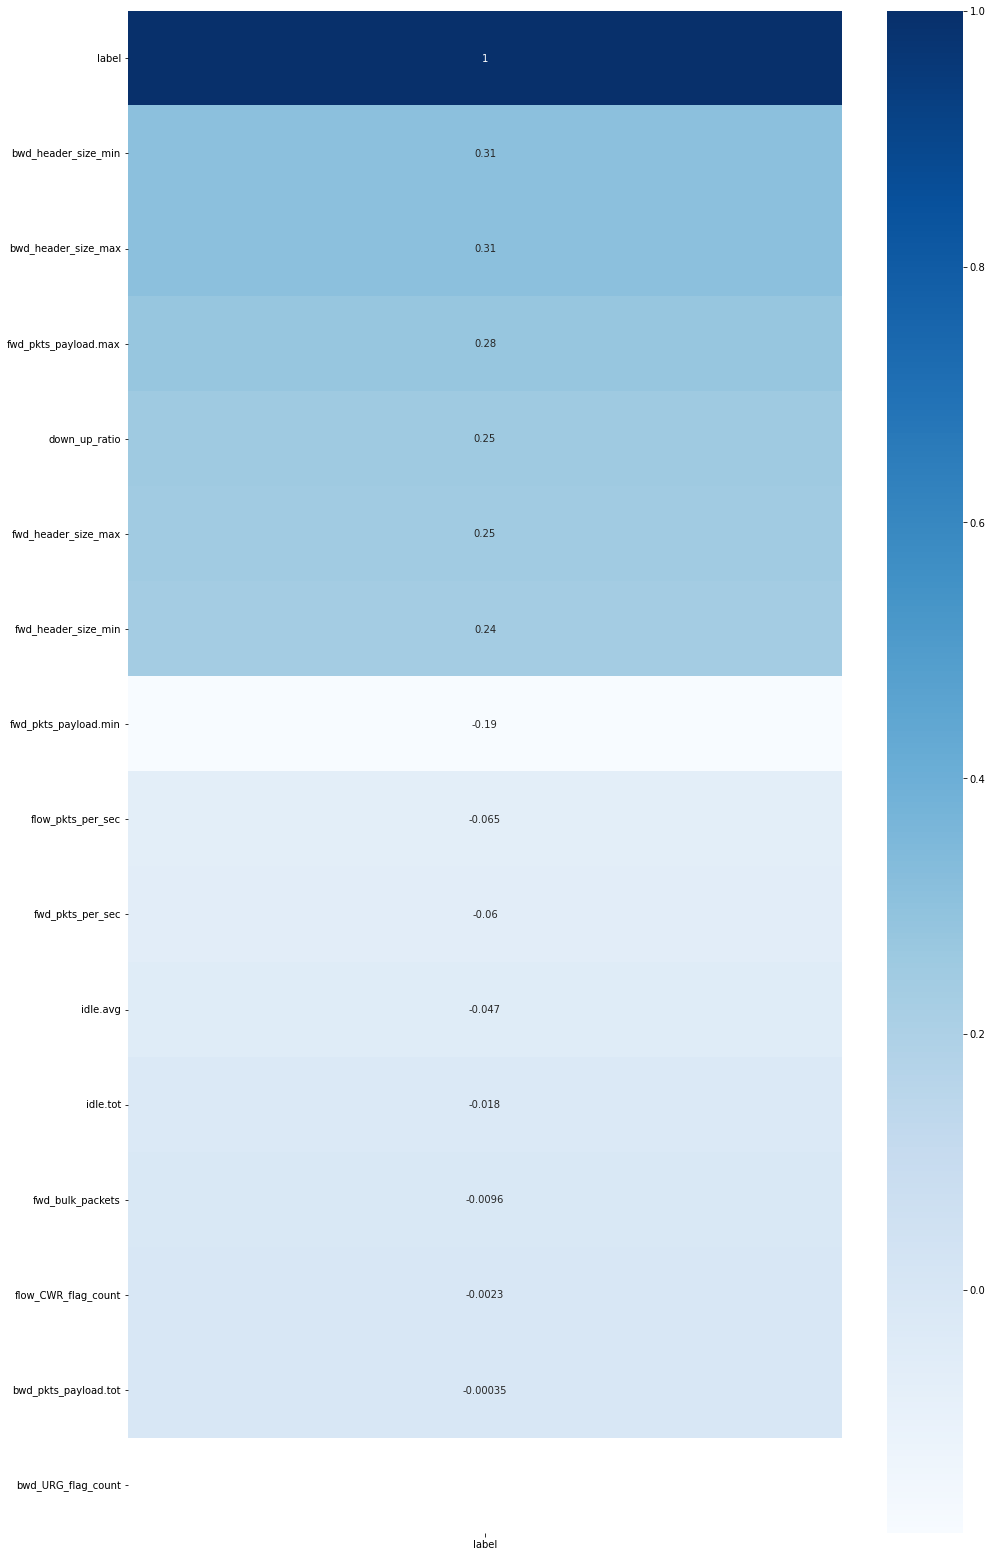

In [ ]:
plt.figure(figsize=(16,28))
sns.heatmap(df_kbest.corr()[['label']].sort_values(by='label', ascending=False, key=abs), annot=True, cmap='Blues');

In [ ]:
df_kbest['label'].value_counts(normalize=True)

0    0.936929
1    0.063071
Name: label, dtype: float64

Major class imbalance (94% / 6%) means there is a need to later look into over or undersampling with SMOTE or NearMiss.

In [ ]:
X = df_kbest.drop(columns=['label'])
y = df_kbest['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [ ]:
# Decided to go with SMOTE for oversampling. Chose to oversample due to undersampling resulting in not enough data for ML and NN models to classify properly.
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

## ML Testing

Train acc: xgb 0.8335111895304982
Test acc: xgb 0.8346816964205455

Train acc: gradientboost 0.8338848801685845
Test acc: gradientboost 0.835077216259461

Train acc: logreg 0.8246196638325249
Test acc: logreg 0.8257285655214569



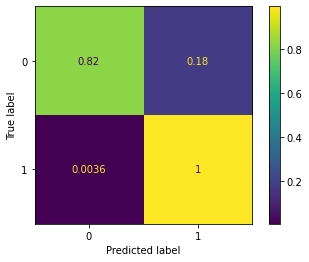

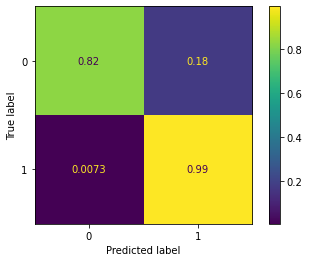

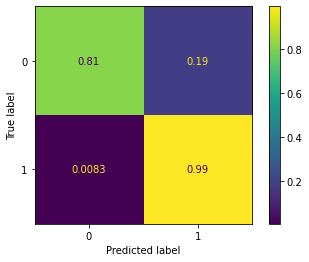

In [ ]:
classifier_dict = { # Testing boosting classifiers to see if there is any effect on false positives, spoilers: there isn't
    'xgb' : XGBClassifier(),
    'gradientboost' : GradientBoostingClassifier(),
    'logreg' : LogisticRegression(
        max_iter=10000,
        random_state=42
    )
}

for model_name, model in classifier_dict.items():  
  pipe_ml = Pipeline([
      ('mms', MinMaxScaler()),
      (model_name, model)
  ])

  pipe_ml.fit(X_train_sm, y_train_sm)

  ConfusionMatrixDisplay.from_estimator(pipe_ml, X_test, y_test, normalize='true');

  print(f'Train acc: {model_name}', pipe_ml.score(X_train, y_train))
  print(f'Test acc: {model_name}', pipe_ml.score(X_test, y_test))

  print('')

## NN Testing

In [ ]:
def create_model():

  model = Sequential()

  model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

  return model

In [ ]:
estimator = KerasClassifier(
    model=create_model,
    epochs=5,
    batch_size=None)

In [ ]:
pipe_nn = Pipeline([
    ('mms', MinMaxScaler()),
    ('nn', estimator)
])

pipe_nn.fit(X_train_sm, y_train_sm)

Epoch 1/5
15201/15201 [==============================] - 43s 3ms/step - loss: 0.2973 - acc: 0.8864
Epoch 2/5
15201/15201 [==============================] - 45s 3ms/step - loss: 0.2631 - acc: 0.9046
Epoch 3/5
15201/15201 [==============================] - 44s 3ms/step - loss: 0.2604 - acc: 0.9057
Epoch 4/5
15201/15201 [==============================] - 46s 3ms/step - loss: 0.2594 - acc: 0.9060
Epoch 5/5
15201/15201 [==============================] - 44s 3ms/step - loss: 0.2585 - acc: 0.9064


Pipeline(steps=[('mms', MinMaxScaler()),
                ('nn',
                 KerasClassifier(epochs=5, model=<function create_model at 0x7f1c6ee21dd0>))])

3477/3477 [==============================] - 5s 2ms/step


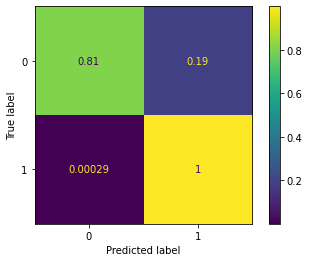

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe_nn, X_test, y_test, normalize='true');